# Introduction to End-To-End Automatic Speech Recognition

This notebook contains a basic tutorial of Automatic Speech Recognition (ASR) concepts, introduced with code snippets using the [NeMo framework](https://github.com/NVIDIA/NeMo).
We will first introduce the basics of the main concepts behind speech recognition, then explore concrete examples of what the data looks like and walk through putting together a simple end-to-end ASR pipeline.

We assume that you are familiar with general machine learning concepts and can follow Python code, and we'll be using the [AN4 dataset from CMU](http://www.speech.cs.cmu.edu/databases/an4/) (with processing using `sox`).

## Conceptual Overview: What is ASR?

ASR, or **Automatic Speech Recognition**, refers to the problem of getting a program to automatically transcribe spoken language (speech-to-text). Our goal is usually to have a model that minimizes the **Word Error Rate (WER)** metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

Traditional speech recognition takes a generative approach, modeling the full pipeline of how speech sounds are produced: from a **language model** that encapsulates likely orderings of words (e.g. an n-gram model), to a **pronunciation model** for each word in the vocabulary (e.g. a pronunciation table), to an **acoustic model** that translates the pronunciations to audio waveforms (e.g. a Gaussian Mixture Model), and so on.

Then, if we receive some spoken input, our goal would be to find the most likely sequence of text that would result in the given audio according to our pipeline of models. Overall, with traditional speech recognition, we try to model `Pr(audio|transcript)*Pr(transcript)`, and take the argmax of this over possible transcripts.

Over time, neural nets advanced to the point where each component of the traditional speech recognition model could be replaced by a neural model that had better performance and that had a greater potential for generalization. For example, we could replace an n-gram model with a neural language model, and replace a pronunciation table with a neural pronunciation model, and so on. However, each of these neural models need to be trained individually on different tasks, and errors in any model in the pipeline could throw off the whole prediction.

Thus, we can see the appeal of **end-to-end ASR architectures**--discriminative models that simply take an audio input and give a textual output, and in which all components are trained together towards the same goal. A much easier pipeline to handle!

### End-To-End ASR

With an end-to-end model, we want to directly learn `Pr(transcript|audio)` in order to predict the transcripts from the original audio. Since we are dealing with sequential information--audio data over time that corresponds to a sequence of letters--RNNs are the obvious choice. But now we have a pressing problem to deal with: since our input sequence (number of audio timesteps) is not the same length as our desired output (transcript length), how do we match each time step from the audio data to the correct output characters?

Earlier speech recognition approaches relied on **temporally-aligned data**, in which each segment of time in an audio file was matched up to a corresponding speech sound such as a phoneme or word. However, if we would like to have the flexibility to predict letter-by-letter to prevent OOV (out of vocabulary) issues, then each time step in the data would have to be labeled with the letter sound that the speaker is making at that point in the audio file. With that information, it seems like we should simply be able to try to predict the correct letter for each time step and then collapse the repeated letters (e.g. the prediction output `LLLAAAAPPTOOOPPPP` would become `LAPTOP`). It turns out that this idea has some problems: not only does alignment make the dataset incredibly labor-intensive to label, but also, what do we do with words like "book" that contain consecutive repeated letters? Simply squashing repeated letters together would not work in that case!

<img src="intro_files/alignment_diagram.png">

Modern end-to-end approaches get around this using methods that don't require manual alignment at all, so that the input-output pairs are really just the raw audio and the transcript--no extra data or labeling required. Let's briefly go over two popular approaches that allow us to do this, Connectionist Temporal Classification (CTC) and sequence-to-sequence models with attention.

#### Connectionist Temporal Classification (CTC)

In normal speech recognition prediction output, we would expect to have characters such as the letters from A through Z, numbers 0 through 9, spaces ("\_"), and so on. CTC introduces a new intermediate output token called the **blank token** ("-") that is useful for getting around the alignment issue.

With CTC, we still predict one token per time segment of speech, but we use the blank token to figure out where we can and can't collapse the predictions. The appearance of a blank token helps separate repeating letters that should not be collapsed. For instance, with an audio snippet segmented into `T=11` time steps, we could get predictions that look like `BOO-OOO--KK`, which would then collapse to `"BO-O-K"`, and then we would remove the blank tokens to get our final output, `BOOK`.

Now, we can predict one output token per time step, then collapse and clean to get sensible output without any fear of ambiguity from repeating letters! A simple way of getting predictions like this would be to apply a bidirectional RNN to the audio input, apply softmax over each time step's output, and then take the token with the highest probability. The method of always taking the best token at each time step is called **greedy decoding, or max decoding**.

To calculate our loss for backprop, we would like to know the log probability of the model producing the correct transcript, `log(Pr(transcript|audio))`. We can get the log probability of a single intermediate output sequence (e.g. `BOO-OOO--KK`) by summing over the log probabilities we get from each token's softmax value, but note that the resulting sum is different from the log probability of the transcript itself (`BOOK`). This is because there are multiple possible output sequences of the same length that can be collapsed to get the same transcript (e.g. `BBO--OO-KKK` also results in `BOOK`), and so we need to **marginalize over every valid sequence of length `T` that collapses to the transcript**.

Therefore, to get our transcript's log probability given our audio input, we must sum of the log probabilities of every sequence of length `T` that collapses to the transcript (e.g. `log(Pr(output: "BOOK"|audio)) = log(Pr(BOO-OOO--KK|audio)) + log(Pr(BBO--OO-KKK|audio)) + ...`). In practice, we can use a dynamic programming approach to calculate this, accumulating our log probabilities over different "paths" through the softmax outputs at each time step.

If you would like a more in-depth explanation of how CTC works, or how we can improve our results by using a modified beam search algorithm, feel free to check out the Further Reading section at the end of this notebook for more resources.

#### Sequence-to-Sequence with Attention

One problem with CTC is that predictions at different time steps are conditionally independent, which is an issue because the words in a continuous utterance tend to be related to each other in some sensible way. With this conditional independence assumption, we can't learn a language model that can represent such dependencies, though we can add a language model on top of the CTC output to mitigate this to some degree.

A popular alternative is to use a sequence-to-sequence model with attention. A typical seq2seq model for ASR consists of some sort of **bidirectional RNN encoder** that consumes the audio sequence timestep-by-timestep, and where the outputs are then passed to an **attention-based decoder**. Each prediction from the decoder is based on attending to some parts of the entire encoded input, as well as the previously outputted tokens.

The outputs of the decoder can be anything from word pieces to phonemes to letters, and since predictions are not directly tied to time steps of the input, we can just continue producing tokens one-by-one until an end token is given (or we reach a specified max output length). This way, we do not need to deal with audio alignment, and our predicted transcript is just the sequence of outputs given by our decoder.

Now that we have an idea of what some popular end-to-end ASR models look like, let's take a look at the audio data we'll be working with for our example.

## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. Please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step (see the "Downloads" section of the main page).

In [1]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

# Untar and convert .sph to .wav (using sox)
tar = tarfile.open(an4_path)
tar.extractall(path=data_dir)

print("Converting .sph to .wav...")
sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
for sph_path in sph_list:
    wav_path = sph_path[:-4] + '.wav'
    cmd = ["sox", sph_path, wav_path]
    subprocess.run(cmd)
print("Finished conversion.\n******")

******
Tarfile already exists.
Converting .sph to .wav...
Finished conversion.
******


You should now have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one (feel free to check this out by listening to `./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav`). In an ASR task, the WAV file would be our input, and "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

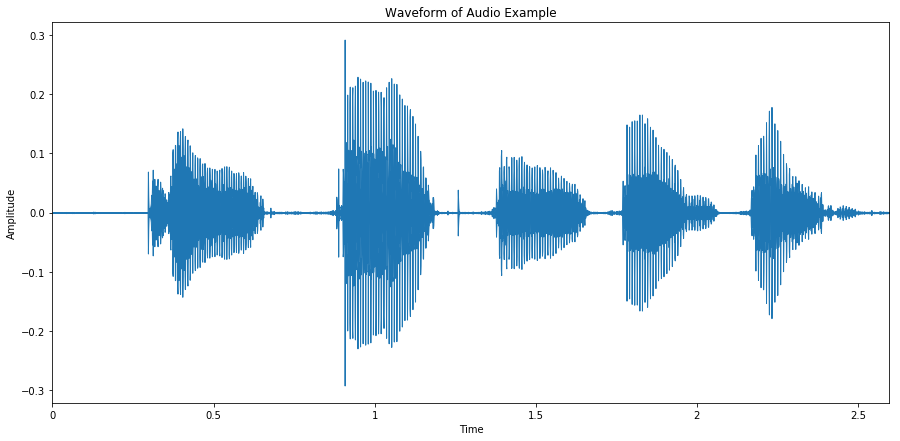

In [3]:
%matplotlib inline
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Plot our example audio file's waveform
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

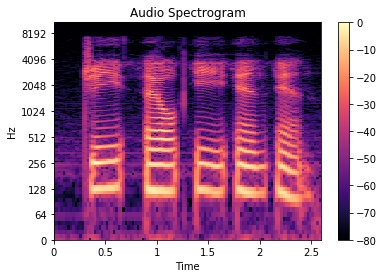

In [4]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we are able to see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

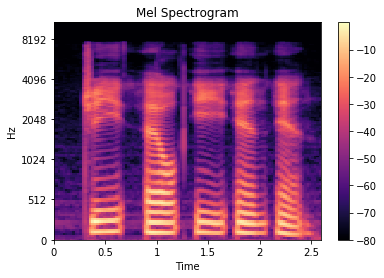

In [5]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

## Building a Simple ASR Pipeline in NeMo

Now that we have an idea of what the audio data looks like, we can start building our end-to-end ASR pipeline!

We'll be using the **Neural Modules (NeMo) toolkit** for this part, so if you haven't already, you should download and install NeMo and its dependencies. To do so, just follow the directions on the [GitHub page](https://github.com/NVIDIA/NeMo), or in the [documentation](https://nvidia.github.io/NeMo/).

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. If you're curious, you can read more about NeMo and how it works in the documentation pages linked above.

In [6]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection
import nemo_asr

### Creating Data Manifests

The first thing we need to do now is to create manifests for our training and evaluation data, which will contain the metadata of our audio files. NeMo data layers take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

Here's an example of what one line in a NeMo-compatible manifest might look like:
```
{"audio_filename": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}
```

We can build our training and evaluation manifests using `an4/etc/an4_train.transcription` and `an4/etc/an4_test.transcription`, which have lines containing transcripts and their corresponding audio file IDs:
```
...
<s> P I T T S B U R G H </s> (cen5-fash-b)
<s> TWO SIX EIGHT FOUR FOUR ONE EIGHT </s> (cen7-fash-b)
...
```

In [7]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filename": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
print("Test manifest created.")
print("******")

******
Training manifest created.
Test manifest created.
******


### Building Training and Evaluation DAGs

Let's take a look at the model that we will be building, and how we specify its parameters.

#### The Jasper Model

We will be putting together a small [Jasper (Just Another SPeech Recognizer) model](https://arxiv.org/abs/1904.03288).
In brief, Jasper architectures consist of a repeated block structure that utilizes 1D convolutions.
In a Jasper_KxR model, `R` sub-blocks (consisting of a 1D convolution, batch norm, ReLU, and dropout) are grouped into a single block, which is then repeated `K` times.
We also have a one extra block at the beginning and a few more at the end that are invariant of `K` and `R`, and we use CTC loss.

A Jasper model looks like roughly this:

![Jasper with CTC](https://raw.githubusercontent.com/NVIDIA/NeMo/master/docs/sources/source/asr/jasper.png)

#### Specifying Our Model with a YAML File

For this tutorial, we'll build a *Jasper_4x1 model*, with `K=4` blocks of single (`R=1`) sub-blocks and a *greedy CTC decoder*, using the configuration found in `./configs/jasper_an4.yaml`.

If we open up this config file, we find that there is an entry labeled `JasperEncoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:
```
- filters: 256
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
```
The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of `K` and `R`.
Next, we have four entries that correspond to the `K=4` blocks, and each has `repeat: 1` since we are using `R=1`.
These are followed by two more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify that we should be shuffling our training data but not our evaluation data (see `AudioToTextDataLayer`), and some specifications for preprocessing the audio data (in `AudioPreprocessing`).

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily.

#### Building Training and Evaluation DAGs with NeMo

Building a model using NeMo consists of (1) instantiating the neural modules we need and (2) specifying the DAG by linking them together.

Let's start by loading the config.

In [8]:
# --- Loading Config --- #
from ruamel.yaml import YAML

# Parse config and pass to model building function
config_path = './configs/jasper_an4.yaml'
yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
    print("******\nLoaded config file.\n******")

labels = params['labels']  # Vocab of tokens
sample_rate = params['sample_rate']

******
Loaded config file.
******


In NeMo, **the training and inference pipelines are managed by a `NeuralModuleFactory`**, which takes care of checkpointing, callbacks, and logs, along with other details in training and inference. We set its `log_dir` argument to specify where our model logs and outputs will be written, and can set other training and inference settings in its constructor. For instance, if we were **resuming training from a checkpoint**, we would set the argument `checkpoint_dir=<path_to_checkpoint>`.

In [9]:
# Create our NeuralModuleFactory, which will oversee the neural modules.
neural_factory = nemo.core.NeuralModuleFactory(
    log_dir=data_dir+'/an4_tutorial/')

logger = neural_factory.logger

Now that we have the configurations and our neural module factory, we can specify our neural modules and instantiate them.

In [10]:
# --- Instantiate Neural Modules --- #

# Create training and test data layers (which load data) and data preprocessor
data_layer_train = nemo_asr.AudioToTextDataLayer(
    manifest_filepath=train_manifest,
    sample_rate=sample_rate,
    labels=labels,
    batch_size=32,
    **params['AudioToTextDataLayer']['train'])  # Training datalayer

data_layer_test = nemo_asr.AudioToTextDataLayer(
    manifest_filepath=test_manifest,
    sample_rate=sample_rate,
    labels=labels,
    batch_size=32,
    **params['AudioToTextDataLayer']['eval'])   # Eval datalayer

data_preprocessor = nemo_asr.AudioPreprocessing(
    sample_rate=sample_rate,
    **params['AudioPreprocessing'])

# Create the Jasper_4x1 encoder as specified, and a CTC decoder
encoder = nemo_asr.JasperEncoder(
    feat_in=params['AudioPreprocessing']['features'], # Number of input features
    **params['JasperEncoder'])

decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=params['JasperEncoder']['jasper'][-1]['filters'],
    num_classes=len(labels))

ctc_loss = nemo_asr.CTCLossNM(num_classes=len(labels))
greedy_decoder = nemo_asr.GreedyCTCDecoder()

2019-09-27 16:09:26,934 - INFO - Dataset loaded with 0.71 hours. Filtered 0.00 hours.
2019-09-27 16:09:26,951 - INFO - Dataset loaded with 0.10 hours. Filtered 0.00 hours.
2019-09-27 16:09:26,960 - INFO - PADDING: 16
2019-09-27 16:09:26,962 - INFO - STFT using conv


The next step is to assemble our training DAG by specifying the inputs to each neural module.

In [11]:
# --- Assemble Training DAG --- #
audio_signal, audio_signal_len, transcript, transcript_len = data_layer_train()

processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)

encoded, encoded_len = encoder(
    audio_signal=processed_signal,
    length=processed_signal_len)

log_probs = decoder(encoder_output=encoded)
preds = greedy_decoder(log_probs=log_probs)  # Training predictions
loss = ctc_loss(
    log_probs=log_probs,
    targets=transcript,
    input_length=encoded_len,
    target_length=transcript_len)

We would like to be able to evaluate our model on the test set, as well, so let's set up the evaluation DAG.

Our **evaluation DAG will reuse most of the parts of the training DAG with the exception of the data layer**, since we are loading the evaluation data from a different file but evaluating on the same model. Note that if we were using data augmentation in training, we would also leave that out in the evaluation DAG.

In [12]:
# --- Assemble Validation DAG --- #
(audio_signal_test, audio_len_test,
 transcript_test, transcript_len_test) = data_layer_test()

processed_signal_test, processed_len_test = data_preprocessor(
    input_signal=audio_signal_test,
    length=audio_len_test)

encoded_test, encoded_len_test = encoder(
    audio_signal=processed_signal_test,
    length=processed_len_test)

log_probs_test = decoder(encoder_output=encoded_test)
preds_test = greedy_decoder(log_probs=log_probs_test)  # Test predictions
loss_test = ctc_loss(
    log_probs=log_probs_test,
    targets=transcript_test,
    input_length=encoded_len_test,
    target_length=transcript_len_test)

### Running the Model

We would like to be able to monitor our model while it's training, so we use **callbacks**. In general, *callbacks are functions that are called at specific intervals over the course of training or inference*, such as at the start or end of every *n* iterations, epochs, etc. The callbacks we'll be using for this are the `SimpleLossLoggerCallback`, which reports the training loss (or another metric of your choosing, such as WER for ASR tasks), and the `EvaluatorCallback`, which regularly evaluates the model on the test set. Both of these callbacks require you to pass in the tensors to be evaluated--these would be the final outputs of the training and eval DAGs above.

Another useful callback is the `CheckpointCallback`, for saving checkpoints at set intervals. We create one here just to demonstrate how it works.

In [13]:
# --- Create Callbacks --- #

# We use these imports to pass to callbacks more complex functions to perform.
from nemo_asr.helpers import monitor_asr_train_progress, \
    process_evaluation_batch, process_evaluation_epoch
from functools import partial

train_callback = nemo.core.SimpleLossLoggerCallback(
    # Notice that we pass in loss, predictions, and the transcript info.
    # Of course we would like to see our training loss, but we need the
    # other arguments to calculate the WER.
    tensors=[loss, preds, transcript, transcript_len],
    # The print_func defines what gets printed.
    print_func=partial(
        monitor_asr_train_progress,
        labels=labels,
        logger=logger)
    )

# We can create as many evaluation DAGs and callbacks as we want,
# which is useful in the case of having more than one evaluation dataset.
# In this case, we only have one.
eval_callback = nemo.core.EvaluatorCallback(
    eval_tensors=[loss_test, preds_test, transcript_test, transcript_len_test],
    user_iter_callback=partial(
        process_evaluation_batch, labels=labels),
    user_epochs_done_callback=partial(
        process_evaluation_epoch, logger=logger),
    eval_step=500  # How often we evaluate the model on the test set
    )

checkpoint_saver_callback = nemo.core.CheckpointCallback(
    folder=data_dir+'/an4_checkpoints',
    step_freq=1000  # How often checkpoints are saved
    )

if not os.path.exists(data_dir+'/an4_checkpoints'):
    os.makedirs(data_dir+'/an4_checkpoints')

Now that we have our model and callbacks set up, **how do we run it**?

Once we create our neural factory and the callbacks for the information that we want to see, we can **start training** by simply calling the train function on the tensors we want to optimize and our callbacks!

In [14]:
# --- Start Training! --- #
neural_factory.train(
    tensors_to_optimize=[loss],
    callbacks=[train_callback, eval_callback, checkpoint_saver_callback],
    optimizer='novograd',
    optimization_params={
        "num_epochs": 150, "lr": 0.01, "weight_decay": 1e-4
    })

# Training for 150 epochs will take a few minutes.

2019-09-27 16:09:34,384 - WARNING - Data Layer does not have any weights to return. This get_weights call returns None.
2019-09-27 16:09:34,394 - INFO - Restoring checkpoint from folder ./an4_checkpoints ...


Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Starting .....
Starting epoch 100


2019-09-27 16:09:34,718 - INFO - Loss: 0.5977364778518677
2019-09-27 16:09:34,720 - INFO - training_batch_WER:  2.49%
2019-09-27 16:09:34,720 - INFO - Prediction: p i t t s b u r g h
2019-09-27 16:09:34,721 - INFO - Reference: p i t t s b u r g h


Step: 3000


2019-09-27 16:09:34,886 - INFO - ==========>>>>>>Evaluation Loss: 20.51009750366211
2019-09-27 16:09:34,886 - INFO - ==========>>>>>>Evaluation WER:  33.38%


Step time: 0.26996731758117676 seconds
Doing Evaluation ..............................
Evaluation time: 0.16466641426086426 seconds


2019-09-27 16:09:34,926 - INFO - Saved checkpoint: ./an4_checkpoints/trainer-STEP-3000.pt
2019-09-27 16:09:36,996 - INFO - Loss: 0.6045877933502197
2019-09-27 16:09:36,996 - INFO - training_batch_WER:  2.27%
2019-09-27 16:09:36,997 - INFO - Prediction: start
2019-09-27 16:09:36,997 - INFO - Reference: start


Step: 3025
Step time: 0.07377791404724121 seconds
Finished epoch 100 in 2.8411781787872314
Starting epoch 101


2019-09-27 16:09:38,967 - INFO - Loss: 0.30791354179382324
2019-09-27 16:09:38,967 - INFO - training_batch_WER:  3.45%
2019-09-27 16:09:38,968 - INFO - Prediction: welve four sixty seven
2019-09-27 16:09:38,968 - INFO - Reference: twelve four sixty seven


Step: 3050
Step time: 0.0699610710144043 seconds
Finished epoch 101 in 2.414435863494873
Starting epoch 102


2019-09-27 16:09:41,019 - INFO - Loss: 0.1525145173072815
2019-09-27 16:09:41,020 - INFO - training_batch_WER:  0.50%
2019-09-27 16:09:41,022 - INFO - Prediction: help
2019-09-27 16:09:41,022 - INFO - Reference: help


Step: 3075
Step time: 0.0853569507598877 seconds
Finished epoch 102 in 2.464724540710449
Starting epoch 103


2019-09-27 16:09:43,069 - INFO - Loss: 0.5645357966423035
2019-09-27 16:09:43,070 - INFO - training_batch_WER:  1.03%
2019-09-27 16:09:43,070 - INFO - Prediction: three six three oh nine six two
2019-09-27 16:09:43,071 - INFO - Reference: three six three oh nine six two


Step: 3100
Step time: 0.08002710342407227 seconds
Finished epoch 103 in 2.475964069366455
Starting epoch 104


2019-09-27 16:09:45,134 - INFO - Loss: 0.5914702415466309
2019-09-27 16:09:45,135 - INFO - training_batch_WER:  3.37%
2019-09-27 16:09:45,135 - INFO - Prediction: z e l i e n o p  e
2019-09-27 16:09:45,135 - INFO - Reference: z e l i e n o p l e


Step: 3125
Step time: 0.08338642120361328 seconds


2019-09-27 16:09:47,251 - INFO - Loss: 0.6602187156677246
2019-09-27 16:09:47,252 - INFO - training_batch_WER:  4.09%
2019-09-27 16:09:47,252 - INFO - Prediction: erase o j t k s thirty fiven
2019-09-27 16:09:47,253 - INFO - Reference: erase o j t k s thirty five


Finished epoch 104 in 2.5196220874786377
Starting epoch 105
Step: 3150
Step time: 0.08566522598266602 seconds


2019-09-27 16:09:49,331 - INFO - Loss: 1.0760064125061035
2019-09-27 16:09:49,331 - INFO - training_batch_WER:  3.11%
2019-09-27 16:09:49,332 - INFO - Prediction: one te
2019-09-27 16:09:49,332 - INFO - Reference: one ten


Step: 3175
Step time: 0.08167839050292969 seconds
Finished epoch 105 in 2.467190742492676
Starting epoch 106


2019-09-27 16:09:51,289 - INFO - Loss: 0.5280484557151794
2019-09-27 16:09:51,289 - INFO - training_batch_WER:  3.93%
2019-09-27 16:09:51,289 - INFO - Prediction: p o m e r a n t z
2019-09-27 16:09:51,290 - INFO - Reference: p o m e r a n t z


Step: 3200
Step time: 0.07869434356689453 seconds
Finished epoch 106 in 2.392036199569702
Starting epoch 107


2019-09-27 16:09:53,341 - INFO - Loss: 0.5159912109375
2019-09-27 16:09:53,341 - INFO - training_batch_WER:  3.30%
2019-09-27 16:09:53,342 - INFO - Prediction: four one two four two two nine eight two eight
2019-09-27 16:09:53,342 - INFO - Reference: four one two four two two nine eight two eight


Step: 3225
Step time: 0.07036519050598145 seconds
Finished epoch 107 in 2.440030097961426
Starting epoch 108


2019-09-27 16:09:55,357 - INFO - Loss: 0.3997844457626343
2019-09-27 16:09:55,357 - INFO - training_batch_WER:  1.64%
2019-09-27 16:09:55,358 - INFO - Prediction: one five two two one
2019-09-27 16:09:55,358 - INFO - Reference: one five two two one


Step: 3250
Step time: 0.09278988838195801 seconds
Finished epoch 108 in 2.451591968536377
Starting epoch 109


2019-09-27 16:09:57,385 - INFO - Loss: 0.34130966663360596
2019-09-27 16:09:57,385 - INFO - training_batch_WER:  1.00%
2019-09-27 16:09:57,386 - INFO - Prediction: rubout l d r w twenty six
2019-09-27 16:09:57,386 - INFO - Reference: rubout l d r w twenty six


Step: 3275
Step time: 0.08426356315612793 seconds


2019-09-27 16:09:59,339 - INFO - Loss: 0.20239011943340302
2019-09-27 16:09:59,339 - INFO - training_batch_WER:  1.01%
2019-09-27 16:09:59,339 - INFO - Prediction: four one two five two one five three three nine
2019-09-27 16:09:59,340 - INFO - Reference: four one two five two one five three three nine


Finished epoch 109 in 2.3457417488098145
Starting epoch 110
Step: 3300
Step time: 0.07641792297363281 seconds


2019-09-27 16:10:01,406 - INFO - Loss: 0.5120572447776794
2019-09-27 16:10:01,407 - INFO - training_batch_WER:  3.37%
2019-09-27 16:10:01,407 - INFO - Prediction: sto
2019-09-27 16:10:01,407 - INFO - Reference: stop


Step: 3325
Step time: 0.07587409019470215 seconds
Finished epoch 110 in 2.4451348781585693
Starting epoch 111


2019-09-27 16:10:03,477 - INFO - Loss: 0.5645537376403809
2019-09-27 16:10:03,477 - INFO - training_batch_WER:  1.61%
2019-09-27 16:10:03,478 - INFO - Prediction: p t k x zero
2019-09-27 16:10:03,478 - INFO - Reference: p t k x zero


Step: 3350
Step time: 0.0713658332824707 seconds
Finished epoch 111 in 2.4949817657470703
Starting epoch 112


2019-09-27 16:10:05,556 - INFO - Loss: 0.454622745513916
2019-09-27 16:10:05,557 - INFO - training_batch_WER:  3.53%
2019-09-27 16:10:05,557 - INFO - Prediction: one thousand
2019-09-27 16:10:05,557 - INFO - Reference: one thousand


Step: 3375
Step time: 0.08321070671081543 seconds
Finished epoch 112 in 2.4917869567871094
Starting epoch 113


2019-09-27 16:10:07,581 - INFO - Loss: 0.17411547899246216
2019-09-27 16:10:07,582 - INFO - training_batch_WER:  1.08%
2019-09-27 16:10:07,582 - INFO - Prediction: one five two two six
2019-09-27 16:10:07,583 - INFO - Reference: one five two two six


Step: 3400
Step time: 0.0753941535949707 seconds
Finished epoch 113 in 2.4260449409484863
Starting epoch 114


2019-09-27 16:10:09,592 - INFO - Loss: 0.14065997302532196
2019-09-27 16:10:09,593 - INFO - training_batch_WER:  0.53%
2019-09-27 16:10:09,594 - INFO - Prediction: p h i l l i p s
2019-09-27 16:10:09,594 - INFO - Reference: p h i l l i p s


Step: 3425
Step time: 0.06841754913330078 seconds


2019-09-27 16:10:11,656 - INFO - Loss: 0.3819359540939331
2019-09-27 16:10:11,657 - INFO - training_batch_WER:  2.21%
2019-09-27 16:10:11,657 - INFO - Prediction: enter forty three forty five
2019-09-27 16:10:11,658 - INFO - Reference: enter forty three forty five


Finished epoch 114 in 2.4524121284484863
Starting epoch 115
Step: 3450
Step time: 0.08339834213256836 seconds


2019-09-27 16:10:13,742 - INFO - Loss: 0.23731990158557892
2019-09-27 16:10:13,743 - INFO - training_batch_WER:  1.73%
2019-09-27 16:10:13,743 - INFO - Prediction: yes
2019-09-27 16:10:13,744 - INFO - Reference: yes


Step: 3475
Step time: 0.07428860664367676 seconds
Finished epoch 115 in 2.4742417335510254
Starting epoch 116


2019-09-27 16:10:15,808 - INFO - Loss: 0.5871143937110901
2019-09-27 16:10:15,809 - INFO - training_batch_WER:  1.68%
2019-09-27 16:10:15,809 - INFO - Prediction: yes
2019-09-27 16:10:15,810 - INFO - Reference: yes


Step: 3500


2019-09-27 16:10:15,973 - INFO - ==========>>>>>>Evaluation Loss: 22.737119674682617
2019-09-27 16:10:15,974 - INFO - ==========>>>>>>Evaluation WER:  30.66%


Step time: 0.06782293319702148 seconds
Doing Evaluation ..............................
Evaluation time: 0.1641979217529297 seconds
Finished epoch 116 in 2.6655375957489014
Starting epoch 117


2019-09-27 16:10:18,021 - INFO - Loss: 0.5704275369644165
2019-09-27 16:10:18,021 - INFO - training_batch_WER:  1.96%
2019-09-27 16:10:18,022 - INFO - Prediction: nine thirty sixty five
2019-09-27 16:10:18,023 - INFO - Reference: nine thirty sixty five


Step: 3525
Step time: 0.08766317367553711 seconds
Finished epoch 117 in 2.485532760620117
Starting epoch 118


2019-09-27 16:10:20,117 - INFO - Loss: 2.3018031120300293
2019-09-27 16:10:20,118 - INFO - training_batch_WER:  8.33%
2019-09-27 16:10:20,118 - INFO - Prediction: sixty seven ten
2019-09-27 16:10:20,118 - INFO - Reference: sixty seven ten


Step: 3550
Step time: 0.06328630447387695 seconds
Finished epoch 118 in 2.51035213470459
Starting epoch 119


2019-09-27 16:10:22,207 - INFO - Loss: 0.4493834376335144
2019-09-27 16:10:22,207 - INFO - training_batch_WER:  4.05%
2019-09-27 16:10:22,209 - INFO - Prediction: yes
2019-09-27 16:10:22,210 - INFO - Reference: yes


Step: 3575
Step time: 0.07725834846496582 seconds


2019-09-27 16:10:24,259 - INFO - Loss: 0.35787972807884216
2019-09-27 16:10:24,260 - INFO - training_batch_WER:  3.47%
2019-09-27 16:10:24,260 - INFO - Prediction: ne five six six eight
2019-09-27 16:10:24,261 - INFO - Reference: one five six six eight


Finished epoch 119 in 2.4625911712646484
Starting epoch 120
Step: 3600
Step time: 0.08603787422180176 seconds


2019-09-27 16:10:26,400 - INFO - Loss: 0.29558366537094116
2019-09-27 16:10:26,401 - INFO - training_batch_WER:  1.52%
2019-09-27 16:10:26,401 - INFO - Prediction: enter four
2019-09-27 16:10:26,402 - INFO - Reference: enter four


Step: 3625
Step time: 0.08724856376647949 seconds
Finished epoch 120 in 2.5361790657043457
Starting epoch 121


2019-09-27 16:10:28,464 - INFO - Loss: 0.18356361985206604
2019-09-27 16:10:28,465 - INFO - training_batch_WER:  2.07%
2019-09-27 16:10:28,465 - INFO - Prediction: fifty six sixty nine
2019-09-27 16:10:28,465 - INFO - Reference: fifty six sixty nine


Step: 3650
Step time: 0.07036042213439941 seconds
Finished epoch 121 in 2.480956792831421
Starting epoch 122


2019-09-27 16:10:30,532 - INFO - Loss: 0.027210865169763565
2019-09-27 16:10:30,533 - INFO - training_batch_WER:  0.00%
2019-09-27 16:10:30,533 - INFO - Prediction: one twenty
2019-09-27 16:10:30,533 - INFO - Reference: one twenty


Step: 3675
Step time: 0.0847780704498291 seconds
Finished epoch 122 in 2.4577062129974365
Starting epoch 123


2019-09-27 16:10:32,538 - INFO - Loss: 0.619290828704834
2019-09-27 16:10:32,538 - INFO - training_batch_WER:  3.21%
2019-09-27 16:10:32,539 - INFO - Prediction: p g h
2019-09-27 16:10:32,539 - INFO - Reference: p g h


Step: 3700
Step time: 0.08376717567443848 seconds
Finished epoch 123 in 2.432003974914551
Starting epoch 124


2019-09-27 16:10:34,592 - INFO - Loss: 1.0084459781646729
2019-09-27 16:10:34,593 - INFO - training_batch_WER:  5.85%
2019-09-27 16:10:34,593 - INFO - Prediction: two six eight three zero two seven
2019-09-27 16:10:34,594 - INFO - Reference: two six eight three zero two seven


Step: 3725
Step time: 0.07062053680419922 seconds


2019-09-27 16:10:36,661 - INFO - Loss: 0.965880274772644
2019-09-27 16:10:36,662 - INFO - training_batch_WER:  3.85%
2019-09-27 16:10:36,662 - INFO - Prediction: seven three zero
2019-09-27 16:10:36,663 - INFO - Reference: seven three zero


Finished epoch 124 in 2.5143885612487793
Starting epoch 125
Step: 3750
Step time: 0.06523966789245605 seconds


2019-09-27 16:10:38,831 - INFO - Loss: 0.9927825927734375
2019-09-27 16:10:38,832 - INFO - training_batch_WER:  7.39%
2019-09-27 16:10:38,832 - INFO - Prediction: one nine oh oh eight
2019-09-27 16:10:38,833 - INFO - Reference: one nine oh oh eight


Step: 3775
Step time: 0.0770418643951416 seconds
Finished epoch 125 in 2.5215394496917725
Starting epoch 126


2019-09-27 16:10:40,831 - INFO - Loss: 0.2620146572589874
2019-09-27 16:10:40,831 - INFO - training_batch_WER:  1.57%
2019-09-27 16:10:40,832 - INFO - Prediction: p i t t s b u r g h
2019-09-27 16:10:40,832 - INFO - Reference: p i t t s b u r g h


Step: 3800
Step time: 0.07649874687194824 seconds
Finished epoch 126 in 2.4645867347717285
Starting epoch 127


2019-09-27 16:10:42,915 - INFO - Loss: 0.29196858406066895
2019-09-27 16:10:42,916 - INFO - training_batch_WER:  0.54%
2019-09-27 16:10:42,916 - INFO - Prediction: w h i t n e y
2019-09-27 16:10:42,916 - INFO - Reference: w h i t n e y


Step: 3825
Step time: 0.07687163352966309 seconds
Finished epoch 127 in 2.483290910720825
Starting epoch 128


2019-09-27 16:10:44,943 - INFO - Loss: 0.488317608833313
2019-09-27 16:10:44,944 - INFO - training_batch_WER:  3.05%
2019-09-27 16:10:44,944 - INFO - Prediction: six eight three five zero four one
2019-09-27 16:10:44,945 - INFO - Reference: six eight three five zero four one


Step: 3850
Step time: 0.08585906028747559 seconds
Finished epoch 128 in 2.431584358215332
Starting epoch 129


2019-09-27 16:10:47,003 - INFO - Loss: 0.18124662339687347
2019-09-27 16:10:47,004 - INFO - training_batch_WER:  1.90%
2019-09-27 16:10:47,004 - INFO - Prediction: r o b e r t
2019-09-27 16:10:47,005 - INFO - Reference: r o b e r t


Step: 3875
Step time: 0.06474447250366211 seconds


2019-09-27 16:10:49,084 - INFO - Loss: 0.26389870047569275
2019-09-27 16:10:49,085 - INFO - training_batch_WER:  1.66%
2019-09-27 16:10:49,085 - INFO - Prediction: enter six
2019-09-27 16:10:49,086 - INFO - Reference: enter six


Finished epoch 129 in 2.497129201889038
Starting epoch 130
Step: 3900
Step time: 0.09111166000366211 seconds


2019-09-27 16:10:51,159 - INFO - Loss: 0.35563966631889343
2019-09-27 16:10:51,160 - INFO - training_batch_WER:  2.76%
2019-09-27 16:10:51,160 - INFO - Prediction: forty three twenty three
2019-09-27 16:10:51,161 - INFO - Reference: forty three twenty three


Step: 3925
Step time: 0.08614706993103027 seconds
Finished epoch 130 in 2.4787089824676514
Starting epoch 131


2019-09-27 16:10:53,242 - INFO - Loss: 0.37339505553245544
2019-09-27 16:10:53,242 - INFO - training_batch_WER:  3.02%
2019-09-27 16:10:53,243 - INFO - Prediction: e z a k o eight
2019-09-27 16:10:53,243 - INFO - Reference: e z a k o eight


Step: 3950
Step time: 0.0780482292175293 seconds
Finished epoch 131 in 2.526638984680176
Starting epoch 132


2019-09-27 16:10:55,368 - INFO - Loss: 0.4064856767654419
2019-09-27 16:10:55,368 - INFO - training_batch_WER:  3.01%
2019-09-27 16:10:55,369 - INFO - Prediction: g l l k h one
2019-09-27 16:10:55,369 - INFO - Reference: g l l k h one


Step: 3975
Step time: 0.07684063911437988 seconds
Finished epoch 132 in 2.5723767280578613
Starting epoch 133


2019-09-27 16:10:57,550 - INFO - Loss: 1.1182174682617188
2019-09-27 16:10:57,550 - INFO - training_batch_WER:  5.53%
2019-09-27 16:10:57,552 - INFO - Prediction: j o h n
2019-09-27 16:10:57,553 - INFO - Reference: j o h n


Step: 4000


2019-09-27 16:10:57,727 - INFO - ==========>>>>>>Evaluation Loss: 19.447086334228516
2019-09-27 16:10:57,727 - INFO - ==========>>>>>>Evaluation WER:  24.84%


Step time: 0.09268712997436523 seconds
Doing Evaluation ..............................
Evaluation time: 0.17330694198608398 seconds


2019-09-27 16:10:57,761 - INFO - Saved checkpoint: ./an4_checkpoints/trainer-STEP-4000.pt


Finished epoch 133 in 2.716501235961914
Starting epoch 134


2019-09-27 16:10:59,775 - INFO - Loss: 0.4697847366333008
2019-09-27 16:10:59,776 - INFO - training_batch_WER:  1.16%
2019-09-27 16:10:59,776 - INFO - Prediction: y f j k two eight
2019-09-27 16:10:59,777 - INFO - Reference: y f j k two eight


Step: 4025
Step time: 0.0832219123840332 seconds


2019-09-27 16:11:01,905 - INFO - Loss: 0.22718602418899536
2019-09-27 16:11:01,906 - INFO - training_batch_WER:  1.01%
2019-09-27 16:11:01,906 - INFO - Prediction: rubout l d r w twenty six
2019-09-27 16:11:01,906 - INFO - Reference: rubout l d r w twenty six


Finished epoch 134 in 2.5257794857025146
Starting epoch 135
Step: 4050
Step time: 0.08905339241027832 seconds


2019-09-27 16:11:03,972 - INFO - Loss: 0.6371215581893921
2019-09-27 16:11:03,973 - INFO - training_batch_WER:  6.33%
2019-09-27 16:11:03,973 - INFO - Prediction: three twele fifty eight
2019-09-27 16:11:03,974 - INFO - Reference: three twelve fifty eight


Step: 4075
Step time: 0.07145237922668457 seconds
Finished epoch 135 in 2.4908254146575928
Starting epoch 136


2019-09-27 16:11:06,085 - INFO - Loss: 0.8164454102516174
2019-09-27 16:11:06,085 - INFO - training_batch_WER:  2.65%
2019-09-27 16:11:06,086 - INFO - Prediction: july twelfth nineteen sixty nine
2019-09-27 16:11:06,086 - INFO - Reference: july twelfth nineteen sixty nine


Step: 4100
Step time: 0.07383918762207031 seconds
Finished epoch 136 in 2.582512855529785
Starting epoch 137


2019-09-27 16:11:08,247 - INFO - Loss: 0.2161979377269745
2019-09-27 16:11:08,247 - INFO - training_batch_WER:  1.83%
2019-09-27 16:11:08,248 - INFO - Prediction: l o o f b o u r r o w
2019-09-27 16:11:08,248 - INFO - Reference: l o o f b o u r r o w


Step: 4125
Step time: 0.08173108100891113 seconds
Finished epoch 137 in 2.533663749694824
Starting epoch 138


2019-09-27 16:11:10,331 - INFO - Loss: 0.20676152408123016
2019-09-27 16:11:10,331 - INFO - training_batch_WER:  2.04%
2019-09-27 16:11:10,332 - INFO - Prediction: go
2019-09-27 16:11:10,332 - INFO - Reference: go


Step: 4150
Step time: 0.08528518676757812 seconds
Finished epoch 138 in 2.5195727348327637
Starting epoch 139


2019-09-27 16:11:12,453 - INFO - Loss: 0.8787131309509277
2019-09-27 16:11:12,454 - INFO - training_batch_WER:  3.93%
2019-09-27 16:11:12,454 - INFO - Prediction: ennter six four five one
2019-09-27 16:11:12,454 - INFO - Reference: enter six four five one


Step: 4175
Step time: 0.07773995399475098 seconds


2019-09-27 16:11:14,478 - INFO - Loss: 0.7824411392211914
2019-09-27 16:11:14,479 - INFO - training_batch_WER:  3.50%
2019-09-27 16:11:14,479 - INFO - Prediction: n e w y o r k
2019-09-27 16:11:14,480 - INFO - Reference: n e w y o r k


Finished epoch 139 in 2.4682233333587646
Starting epoch 140
Step: 4200
Step time: 0.06934380531311035 seconds


2019-09-27 16:11:16,571 - INFO - Loss: 0.4824211299419403
2019-09-27 16:11:16,572 - INFO - training_batch_WER:  2.82%
2019-09-27 16:11:16,572 - INFO - Prediction: help
2019-09-27 16:11:16,573 - INFO - Reference: help


Step: 4225
Step time: 0.07831192016601562 seconds
Finished epoch 140 in 2.4718117713928223
Starting epoch 141


2019-09-27 16:11:18,623 - INFO - Loss: 0.772219717502594
2019-09-27 16:11:18,623 - INFO - training_batch_WER:  1.47%
2019-09-27 16:11:18,624 - INFO - Prediction: v a n d e r l a a n
2019-09-27 16:11:18,624 - INFO - Reference: v a n d e r l a a n


Step: 4250
Step time: 0.09127068519592285 seconds
Finished epoch 141 in 2.526379346847534
Starting epoch 142


2019-09-27 16:11:20,741 - INFO - Loss: 0.375532329082489
2019-09-27 16:11:20,741 - INFO - training_batch_WER:  1.08%
2019-09-27 16:11:20,742 - INFO - Prediction: one five two two one
2019-09-27 16:11:20,742 - INFO - Reference: one five two two one


Step: 4275
Step time: 0.07440972328186035 seconds
Finished epoch 142 in 2.5254924297332764
Starting epoch 143


2019-09-27 16:11:22,830 - INFO - Loss: 0.07405541837215424
2019-09-27 16:11:22,831 - INFO - training_batch_WER:  0.58%
2019-09-27 16:11:22,831 - INFO - Prediction: i d m h seven eight five
2019-09-27 16:11:22,832 - INFO - Reference: i d m h seven eight five


Step: 4300
Step time: 0.08733272552490234 seconds
Finished epoch 143 in 2.4761996269226074
Starting epoch 144


2019-09-27 16:11:24,908 - INFO - Loss: 0.32671546936035156
2019-09-27 16:11:24,909 - INFO - training_batch_WER:  1.51%
2019-09-27 16:11:24,909 - INFO - Prediction: c o n c o r d
2019-09-27 16:11:24,910 - INFO - Reference: c o n c o r d


Step: 4325
Step time: 0.07602262496948242 seconds


2019-09-27 16:11:26,946 - INFO - Loss: 0.17561854422092438
2019-09-27 16:11:26,946 - INFO - training_batch_WER:  1.57%
2019-09-27 16:11:26,947 - INFO - Prediction: x e d v seven
2019-09-27 16:11:26,947 - INFO - Reference: x e d v seven


Finished epoch 144 in 2.458042621612549
Starting epoch 145
Step: 4350
Step time: 0.07766556739807129 seconds


2019-09-27 16:11:29,092 - INFO - Loss: 0.6435456275939941
2019-09-27 16:11:29,093 - INFO - training_batch_WER:  1.96%
2019-09-27 16:11:29,093 - INFO - Prediction: p i t t s b u r g h
2019-09-27 16:11:29,094 - INFO - Reference: p i t t s b u r g h


Step: 4375
Step time: 0.07919907569885254 seconds
Finished epoch 145 in 2.550992012023926
Starting epoch 146


2019-09-27 16:11:31,170 - INFO - Loss: 1.296973705291748
2019-09-27 16:11:31,171 - INFO - training_batch_WER:  5.29%
2019-09-27 16:11:31,171 - INFO - Prediction: one five two three two
2019-09-27 16:11:31,171 - INFO - Reference: one five two three two


Step: 4400
Step time: 0.06984066963195801 seconds
Finished epoch 146 in 2.5557143688201904
Starting epoch 147


2019-09-27 16:11:33,284 - INFO - Loss: 0.6229705214500427
2019-09-27 16:11:33,284 - INFO - training_batch_WER:  3.80%
2019-09-27 16:11:33,285 - INFO - Prediction: no
2019-09-27 16:11:33,285 - INFO - Reference: no


Step: 4425
Step time: 0.0756380558013916 seconds
Finished epoch 147 in 2.501851797103882
Starting epoch 148


2019-09-27 16:11:35,431 - INFO - Loss: 0.5584088563919067
2019-09-27 16:11:35,431 - INFO - training_batch_WER:  2.92%
2019-09-27 16:11:35,432 - INFO - Prediction: s f q q k six thosand eight hundred and eighty one
2019-09-27 16:11:35,432 - INFO - Reference: s f q q k six thousand eight hundred and eighty one


Step: 4450
Step time: 0.08777880668640137 seconds
Finished epoch 148 in 2.506939649581909
Starting epoch 149


2019-09-27 16:11:37,478 - INFO - Loss: 1.9120776653289795
2019-09-27 16:11:37,478 - INFO - training_batch_WER:  4.57%
2019-09-27 16:11:37,479 - INFO - Prediction: fifty six thirty two
2019-09-27 16:11:37,479 - INFO - Reference: fifty six thirty two


Step: 4475
Step time: 0.07651376724243164 seconds


2019-09-27 16:11:39,638 - INFO - ==========>>>>>>Evaluation Loss: 30.416059494018555
2019-09-27 16:11:39,639 - INFO - ==========>>>>>>Evaluation WER:  37.39%
2019-09-27 16:11:39,673 - INFO - Saved checkpoint: ./an4_checkpoints/trainer-STEP-4500.pt


Finished epoch 149 in 2.5035088062286377
Done in 125.08838772773743
Final Evaluation ..............................
Evaluation time: 0.15727019309997559 seconds


There we go! We've put together a full training pipeline for the model and trained it for 150 epochs.

### Inference

What if we have a trained model that we **just want to run inference** on?

In that case, we just need to instantiate and link up the modules needed for the evaluation DAG (same procedure as before), and then run `infer` to get the results. Let's see what performing inference with our last checkpoint would look like.

In [15]:
# --- Inference Only --- #

# We've already built the inference DAG above, so all we need is to call infer().
evaluated_tensors = neural_factory.infer(
    # These are the tensors we want to get from the model.
    tensors=[loss_test, preds_test, transcript_test, transcript_len_test],
    # checkpoint_dir specifies where the model params are loaded from.
    checkpoint_dir=(data_dir+'/an4_checkpoints')
    )

# Process the results to get WER
from nemo_asr.helpers import word_error_rate, \
    post_process_predictions, post_process_transcripts

greedy_hypotheses = post_process_predictions(
    evaluated_tensors[1], labels)

references = post_process_transcripts(
    evaluated_tensors[2], evaluated_tensors[3], labels)

wer = word_error_rate(hypotheses=greedy_hypotheses, references=references)
print("*** Greedy WER: {:.2f} ***".format(wer * 100))

2019-09-27 16:14:08,567 - INFO - Restoring JasperEncoder from ./an4_checkpoints/JasperEncoder-STEP-4500.pt
2019-09-27 16:14:08,599 - INFO - Restoring JasperDecoderForCTC from ./an4_checkpoints/JasperDecoderForCTC-STEP-4500.pt


Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Evaluating batch 0 out of 5
Evaluating batch 1 out of 5
Evaluating batch 2 out of 5
Evaluating batch 3 out of 5
Evaluating batch 4 out of 5
*** Greedy WER: 37.65 ***


And that's it!

## Model Improvements

In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

In [16]:
# Create a SpectrogramAugmentation module
spectrogram_aug = nemo_asr.SpectrogramAugmentation(
    rect_masks=5, rect_time=120, rect_freq=50)

# Rearrange training DAG to use augmentation.
# The following code is mostly copy/pasted from the "Assemble Training DAG"
# section, with only one line added!
audio_signal, audio_signal_len, transcript, transcript_len = data_layer_train()

processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)

############## This is the only part that's changed! ##############
processed_signal_aug = spectrogram_aug(input_spec=processed_signal)

encoded, encoded_len = encoder(
    audio_signal=processed_signal_aug,  # Change this argument too
    length=processed_signal_len)
###################################################################

log_probs = decoder(encoder_output=encoded)
preds = greedy_decoder(log_probs=log_probs)  # Training predictions
loss = ctc_loss(
    log_probs=log_probs,
    targets=transcript,
    input_length=encoded_len,
    target_length=transcript_len)

# And then you can train as usual.

Another popular method of ASR data augmentation is speed perturbation, where the audio is sped up or slowed down slightly (e.g. 10% faster or slower), but that's currently not available as an option in NeMo yet.

### Using a Language Model

Though a language model may not be especially suited to a task like AN4 where we have a bunch of letters being read in sequence, adding a language model for inference can the improve WER in most other ASR tasks, where the speech more closely matches normal patterns. We can use the probability distribution that a language model gives us to better match our predictions to sequences of words we would be more likely to see in the real world, such as correcting "keyboard and house" to "keyboard and mouse."

If you have a language model that you'd like to use with a NeMo model, you can add a `BeamSearchDecoderWithLM` module to your DAG to get beam search predictions that use your language model file.

```python
# Instantiating the module
beam_search_lm = nemo_asr.BeamSearchDecoderWithLM(
    vocab=labels, beam_width=16,
    alpha=2, beta=1.5,
    lm_path="<path/to/language/model>"
)
...
# In the DAG
beam_predictions = beam_search_lm(log_probs=log_probs, lob_probs_len=encoded_len)
```

### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can read more about both mixed precision and multi-GPU training using NeMo on [this page of the documentation](https://nvidia.github.io/NeMo/training.html).

## Further reading/watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)